# Library

In [1]:
import os
import math
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Parameter

In [2]:
#MODEL PARAMETER
DATA_OFFSET     = 1                                                 # data preprocess offset
INPUT_SIZE      = 1                                                 # the number of input data feature
NUM_LAYERS      = 1                                                 # staked RNN
HIDDEN_SIZE     = 8                                                 # hidden layer 8
NUM_CLASSES     = 1                                                 # the number of output data feature

# HYPERPARAMETER
SEQ_LEN         = 20                                                # sequence length
BATCH_SIZE      = 9984                                              # batch size (32 * 312)
CRITERION       = nn.MSELoss()                                      # mean square error
LEARNING_RATE   = 1e-3                                              # learning rate
NUM_EPOCHS      = 100                                               # epoch

#DATA PARAMETER
TRAIN_NUM          = 600                                            # train number == #iteration -> 6 set
TEST_NUM           = 200                                            # test number                 -> 
DATASET_NUM        = TRAIN_NUM + TEST_NUM                           # dataset number (800)

# PlOT PARAMETER
SET_NUM         = 9984                                              # set size
SAMPLE_PER_SET  = 100                                               # sample size per set
SAMPLE_NUM      = SET_NUM * SAMPLE_PER_SET                          # sample: 998,400
TEST_SIZE       = SET_NUM * TEST_NUM                                # test size (9984 * 180)
SPLIT           = SET_NUM * DATASET_NUM - TEST_SIZE                 # plot test number (9984 * 800 - 9984 * 200) = train number

#Data local parameter
SaturationForRange = SEQ_LEN + DATA_OFFSET                          # prevent idx error


# Data Padding

data가 반복되기 때문에 앞에 data를 padding 하는 것이 올바른 방안이라고 생각

In [3]:
pl = pd.read_table(f'C:/Users/DCLAB/Desktop/Dataset/dataset.csv', sep=',')

# GPU

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is available.')

cuda:0 is available.


# Default Dataset

-> no few shot 

-> 998400 * 6  -> trainset

-> 998400 * 2  -> testset

In [5]:
# seq_data
def seq_data(x, y, seq_len): # sequence length
    X_seq = []
    y_seq = []
    
    for i in range(len(x)-SaturationForRange):
            X_seq.append(x[i:i+seq_len])
            y_seq.append(y[i+seq_len+1])

    X_seq = np.array(X_seq)        
    y_seq = np.array(y_seq)

    return torch.FloatTensor(X_seq).to(device), torch.FloatTensor(y_seq).to(device).view([-1, 1]) 

def train_test_seperate(X, y, seq_len, split, batch_size):
    X_seq, y_seq = seq_data(X, y, seq_len)
    X_train_seq = X_seq[:split]
    y_train_seq = y_seq[:split]
    X_test_seq = X_seq[split:]
    y_test_seq = y_seq[split:]

    # Dataset
    train = torch.utils.data.TensorDataset(X_train_seq, y_train_seq)
    test  = torch.utils.data.TensorDataset(X_test_seq, y_test_seq)

    # Dataloader -> batch_size
    train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False)
    test_loader  = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# TrainSet - FewShot Learning

5 task -> 10-shot, 20 sequence

In [6]:
# Meta learning (Few shot dataset - random: 1 ~ 7,987,200)
def sample_data(x, y, seq_len, FewShotDataNum):
    x_seq = []
    y_seq = []
    
    #not hidden size -> map dataset (8)
    RandomDataSetIdx = random.randint(0, 5)
    Idx_RangeX = RandomDataSetIdx * SAMPLE_NUM
    Idx_RangeY = Idx_RangeX + SAMPLE_NUM - SaturationForRange - FewShotDataNum
    #Random location per 1 random Map
    RandomDataSetloc = random.randint(Idx_RangeX, Idx_RangeY)

    RangeX = RandomDataSetloc
    RangeY = RandomDataSetloc + FewShotDataNum
    
    for i in range(RangeX, RangeY):
            x_seq.append(x[i:i+seq_len])
            y_seq.append(y[i+seq_len+1])

    x_seq = np.array(x_seq)        
    y_seq = np.array(y_seq)

    return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view([-1, 1]) 

# TestSet -> SAMPLE_NUM = 9984

998400 == 1 map 

--> random으로 두 개 중 하나의 task가 나와서 예측

In [7]:
# Meta learning (Few shot dataset - random: 1 ~ 7,987,200)
def Test_data(x, y, seq_len):
    x_seq = []
    y_seq = []

    RandomDataSetIdx = random.randint(6, 7)     #not hidden size -> map dataset (8)
    RandomDataSetloc = SAMPLE_NUM * RandomDataSetIdx
    
    RangeX = RandomDataSetloc
    RangeY = SAMPLE_NUM + RandomDataSetloc - SaturationForRange

    for i in range(RangeX, RangeY):
            x_seq.append(x[i:i+seq_len])
            y_seq.append(y[i+seq_len+1])

    x_seq = np.array(x_seq)        
    y_seq = np.array(y_seq)

    return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view([-1, 1]) 

# TestSet

--> random으로 두 개 중 하나의 task에서 user 100개 중 random result 1개 예측하는 dataset

In [8]:
# Meta learning (Few shot dataset - random: 1 ~ 7,987,200)
def One_Test_data(x, y, seq_len):
    x_seq = []
    y_seq = []

    RandomDataSetIdx = random.randint(6, 8)                     # not hidden size -> map dataset (8)
    RandomDataResultIdx = random.randint(0, 99)                 # 100 result per map
    RandomDataSetloc = BATCH_SIZE * RandomDataSetIdx * RandomDataResultIdx

    RangeX = RandomDataSetloc
    RangeY = BATCH_SIZE + RandomDataSetloc - SaturationForRange

    for i in range(RangeX, RangeY):
            x_seq.append(x[i:i+seq_len])
            y_seq.append(y[i+seq_len+1])

    x_seq = np.array(x_seq)        
    y_seq = np.array(y_seq)

    return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view([-1, 1]) 

# check the DATASET & Apply

In [9]:
X = pl[["Realized_Power"]].values
y = pl["Real_block"].values

In [10]:
#train, test dataset
train_loader, test_loader = train_test_seperate(X, y, SEQ_LEN, SPLIT, BATCH_SIZE)

In [11]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

test_features, test_labels = next(iter(test_loader))
print(f"Feature batch shape: {test_features.size()}")
print(f"Labels batch shape: {test_labels.size()}")

Feature batch shape: torch.Size([9984, 20, 1])
Labels batch shape: torch.Size([9984, 1])
Feature batch shape: torch.Size([9984, 20, 1])
Labels batch shape: torch.Size([9984, 1])


In [12]:
def model_training(train_loader, num_epochs, model, criterion, optimizer): 
    loss_graph = []
    n = len(train_loader)

    for epoch in range(num_epochs): # epoch
        running_loss = 0.0  
        
        for i, data in enumerate(train_loader): # batch 
            seq, target = data
            out = model(seq)
            loss = criterion(out, target)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        loss_graph.append(running_loss/n)
        
        if epoch % 10 == 0:
            print('[epoch: %d] loss: %.8f' %(epoch, running_loss/n))
    
    plt.figure(figsize=(20,10))
    plt.plot(loss_graph)

# LSTM cell 구현

In [13]:
class LSTMCell(nn.Module) :
    def __init__(self, input_size, hidden_size, bias=True) :
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.x2h = nn.Linear(input_size, 4*hidden_size, bias=bias) 
        self.h2h = nn.Linear(hidden_size, 4*hidden_size, bias=bias)
        self.reset_parameters()
        
    def reset_parameters(self) :
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters() :
            w.data.uniform_(-std, std)
            
    def forward(self, x, hidden_size) :
        hx, cx = hidden_size
        x = x.view(-1, x.size(1))
        
        gates = self.x2h(x) + self.h2h(hx)
        gates = gates.squeeze()
        InputGate, ForgetGate, CellGate, OutGate = gates.chunk(4, -1)
        
        InputGate = F.sigmoid(InputGate)          
        ForgetGate = F.sigmoid(ForgetGate)  
        CellGate = F.tanh(CellGate)         
        OutGate = F.sigmoid(OutGate)        
        
        # cy = ForgetGate * cx + InputGate *  CellGate
        cy = torch.mul(cx, ForgetGate) + torch.mul(InputGate, CellGate)
        hy = torch.mul(OutGate, F.tanh(cy))
        
        return (hy, cy)

# LSTM model

In [14]:
class MAMLModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, device, num_classes):
        super(MAMLModel, self).__init__()
        self.input_size = input_size
        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTMCell(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size*SEQ_LEN, num_classes) #hidden size per length
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        Initial_HiddenState = Variable(torch.Tensor(torch.zeros(self.num_layers, x.size(0), self.hidden_size))).to(device)
        Initial_CellState = Variable(torch.Tensor(torch.zeros(self.num_layers, x.size(0), self.hidden_size))).to(device)

        out = []
        CellState = Initial_CellState[0,:,:]
        HiddenState = Initial_HiddenState[0,:,:]
    
        for seq in range(x.size(1)) :
            HiddenState, CellState = self.lstm(x[:, seq, :], (HiddenState, CellState))
            out.append(HiddenState.unsqueeze(1))
        
        out = torch.cat(out, dim=1) #10, 20, 8
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        out = self.sigmoid(out)
        return out
    
    # FewshotDataset -> initial point
    def parameterised(self, x, weights):
        InputGate_Weight, ForgetGate_Weight, CellGate_Weight, OutputGate_Weight = weights[0].split(8, dim=0)
        InputGate_bias, ForgetGate_bias, CellGate_bias, OutputGate_bias = weights[2].split(8, dim=0)

        InputGate_HiddenWeight, ForgetGate_HiddenWeight, CellGate_HiddenWeight, OutputGate_HiddenWeight = weights[1].split(8, dim=0)
        InputgetGate_HiddenBias, ForgetGate_HiddenBias, CellGate_HiddenBias, OutputGate_HiddenBias = weights[3].split(8, dim=0)

        Initial_HiddenState = Variable(torch.Tensor(torch.zeros(self.num_layers, x.size(0), self.hidden_size))).to(device)
        Initial_CellState = Variable(torch.Tensor(torch.zeros(self.num_layers, x.size(0), self.hidden_size))).to(device)
        CellState = Initial_CellState[0,:,:]
        HiddenState = Initial_HiddenState[0,:,:]

        out = []
        for seq in range(x.size(1)):
            InputGate = torch.sigmoid(F.linear(x[:, seq, :], InputGate_Weight, InputGate_bias) + F.linear(HiddenState, InputGate_HiddenWeight, InputgetGate_HiddenBias))
            ForgetGate = torch.sigmoid(F.linear(x[:, seq, :], ForgetGate_Weight, ForgetGate_bias) + F.linear(HiddenState, ForgetGate_HiddenWeight, ForgetGate_HiddenBias))
            CellGate = torch.tanh(F.linear(x[:, seq, :], CellGate_Weight, CellGate_bias) + F.linear(HiddenState, CellGate_HiddenWeight, CellGate_HiddenBias))
            OutputGate = torch.sigmoid(F.linear(x[:, seq, :], OutputGate_Weight, OutputGate_bias) + F.linear(HiddenState, OutputGate_HiddenWeight, OutputGate_HiddenBias))
            CellState = ForgetGate * CellState + InputGate * CellGate
            HiddenState = OutputGate * torch.tanh(CellState) # (10, 8) x 20
            out.append(HiddenState.unsqueeze(1))

        out = torch.cat(out, dim=1) #10, 20, 8
        out = out.reshape(out.shape[0], -1)
        x = F.linear(out, weights[4], weights[5])
        x = torch.sigmoid(x)

        return x


In [15]:
model = MAMLModel(input_size=INPUT_SIZE, 
                   hidden_size=HIDDEN_SIZE, 
                   num_layers=NUM_LAYERS, 
                   num_classes=NUM_CLASSES, 
                   device=device)

model=model.to(device)

# check the model weights
0 -> torch size (x2h)

1 -> torch size (h2h)

2 -> 0의 bias

3 -> 1의 bias

4 -> linear

5 -> bias

In [16]:
for name, param in enumerate(model.parameters()):
    print(name,param.shape)

0 torch.Size([32, 1])
1 torch.Size([32, 8])
2 torch.Size([32])
3 torch.Size([32])
4 torch.Size([1, 160])
5 torch.Size([1])


# Meta Learning --> inner loop, Few-shot Learning

In [17]:
class MAML():
    def __init__(self, model, inner_lr, meta_lr, K=10, inner_steps=1, tasks_per_meta_batch=10):
        
        # important objects
        self.model = model
        self.weights = list(model.parameters()) # the maml weights we will be meta-optimising
        self.criterion = CRITERION
        self.meta_optimiser = torch.optim.Adam(self.weights, meta_lr)
        
        # hyperparameters
        self.inner_lr = inner_lr
        self.meta_lr = meta_lr
        self.K = K
        self.inner_steps = inner_steps # with the current design of MAML, >1 is unlikely to work well 
        self.tasks_per_meta_batch = tasks_per_meta_batch 
        
        # metrics
        self.plot_every = 100
        self.print_every = 1000
        self.meta_losses = []
    
    # Meta Learning
    def inner_loop(self):
        # reset inner model to current maml weights
        temp_weights = [w.clone() for w in self.weights]
        
        X = pl[["Realized_Power"]].values
        y = pl["Real_block"].values
        
        X, y = sample_data(X, y, SEQ_LEN, self.K)

        # perform training on data sampled from 5 task
        for step in range(10):
            loss = self.criterion(self.model.parameterised(X, temp_weights), y) / self.K
            # compute grad and update inner loop weights
            grad = torch.autograd.grad(loss, temp_weights, allow_unused=True) #True extremely important
            modified_tuple = tuple(0 if item is None else item for item in grad)
            temp_weights = [w - self.inner_lr * g for w, g in zip(temp_weights, modified_tuple)]
        self.weights = temp_weights
    
    def main_loop(self, num_iterations):
        epoch_loss = 0
        meta_loss = 0

        # inner_loop -> meta learning (Few-shot dataset)
        for i in range(self.tasks_per_meta_batch):
            self.inner_loop()
            
        for iteration in range(1, num_iterations+1):
            X = pl[["Realized_Power"]].values
            y = pl["Real_block"].values
            
            seq, taget = sample_data(X, y, SEQ_LEN, self.K)
            out = self.model(seq)
            meta_loss = self.criterion(out, taget) / self.K
            model.zero_grad()
            meta_loss.backward()
            self.meta_optimiser.step()
                    
            # log metrics
            epoch_loss += meta_loss.item() / self.tasks_per_meta_batch

            if iteration % self.print_every == 0:
                print("{}/{}. loss: {}".format(iteration, num_iterations, epoch_loss / self.plot_every))
            
            if iteration % self.plot_every == 0:
                self.meta_losses.append(epoch_loss / self.plot_every)
                epoch_loss = 0

In [18]:
maml = MAML(model, inner_lr=0.001, meta_lr=0.001)

In [19]:
maml.main_loop(num_iterations=10000)

1000/10000. loss: 0.0021871082559227935
2000/10000. loss: 0.0020860243936185723
3000/10000. loss: 0.001992314993869514
4000/10000. loss: 0.002196364736650139
5000/10000. loss: 0.0018137654339661824
6000/10000. loss: 0.0021632821137754945
7000/10000. loss: 0.001802411390804082
8000/10000. loss: 0.0018406576627476696
9000/10000. loss: 0.0013658840834733365
10000/10000. loss: 0.000926648901402123


# Loss

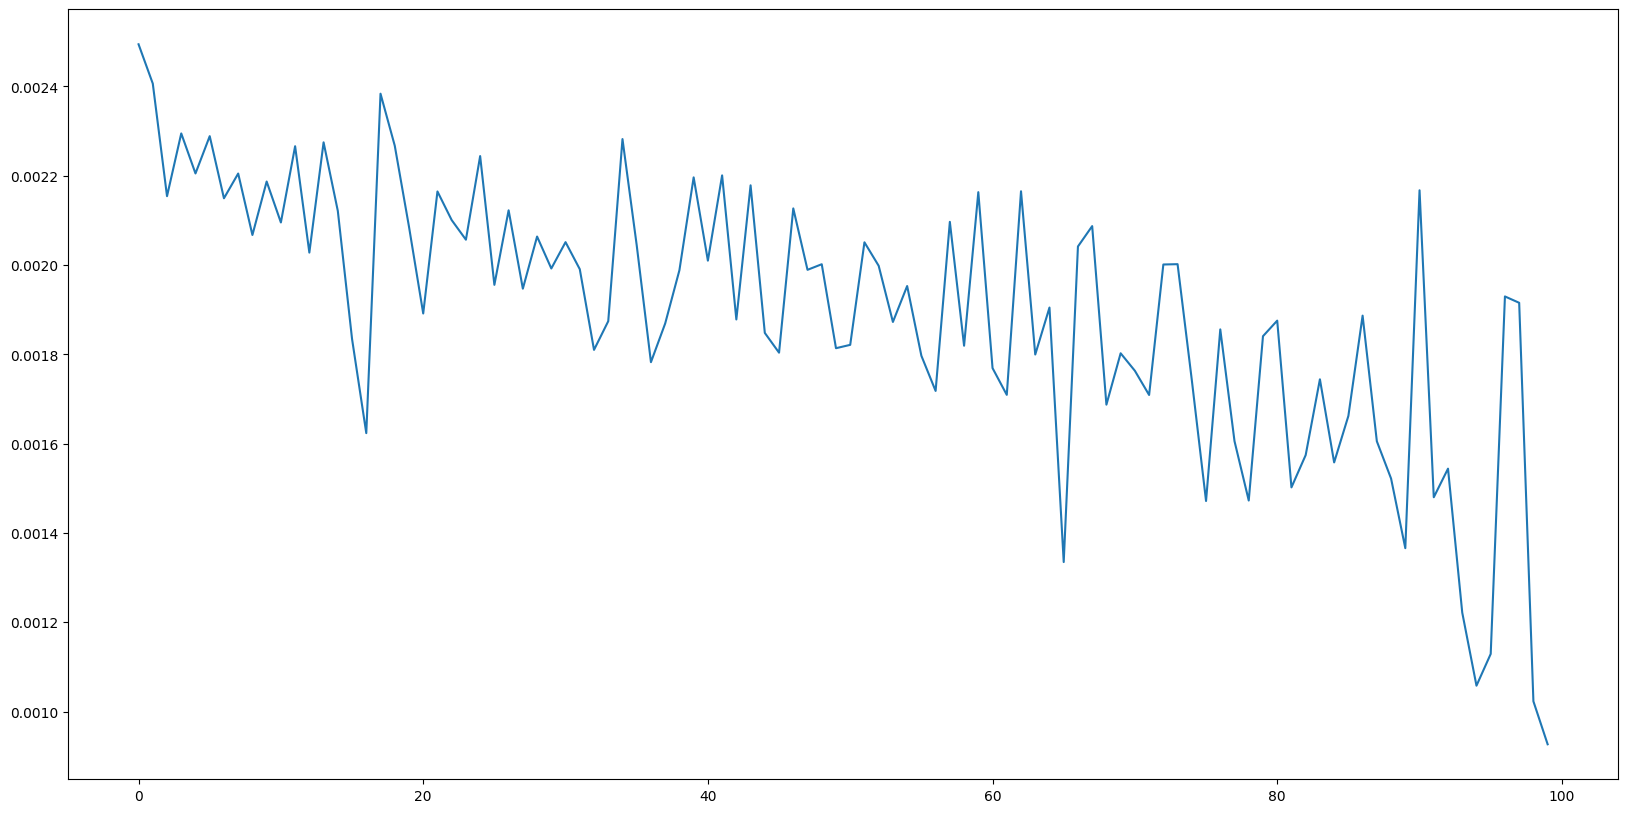

In [20]:
plt.figure(figsize=(20,10))
plt.plot(maml.meta_losses)

# MetaLearning 적용 x --> model

In [21]:
def mixed_pretrained(iterations=500, K=10):
    """
    returns a model pretrained on a selection of ``iterations`` random tasks.
    """
    
    # set up model
    pretrain_model = MAMLModel(input_size=INPUT_SIZE, 
                   hidden_size=HIDDEN_SIZE, 
                   num_layers=NUM_LAYERS,
                   num_classes=NUM_CLASSES, 
                   device=device).to(device)
    
    optimiser = torch.optim.Adam(pretrain_model.parameters(), lr=0.01)
    criterion = nn.MSELoss()

    X = pl[["Realized_Power"]].values
    y = pl["Real_block"].values

    # fit the model
    for i in range(iterations):
        seq, target = sample_data(X, y, SEQ_LEN, K)
        out = pretrain_model(seq)
        #print(seq, target) = feature, label
        loss = criterion(out, target) 
        pretrain_model.zero_grad()
        loss.backward()
        optimiser.step()
        
    return pretrain_model

In [22]:
pretrained_model = mixed_pretrained(10000, 10).to(device)

# Result 1

In [23]:
def model_functions_at_training(initial_model, X, y, sampled_steps, optim=torch.optim.Adam, lr=0.01):
    """
    trains the model on X, y and measures the loss curve.
    
    for each n in sampled_steps, records model(x_axis) after n gradient updates.
    """
    
    # copy MAML model into a new object to preserve MAML weights during training
    
    model = MAMLModel(input_size=INPUT_SIZE, 
                   hidden_size=HIDDEN_SIZE, 
                   num_layers=NUM_LAYERS,
                   num_classes=NUM_CLASSES, 
                   device=device).to(device)

    model.load_state_dict(initial_model.state_dict())
    criterion = CRITERION
    optimiser = optim(model.parameters(), lr)

    # train model on a random task
    num_steps = max(sampled_steps)
    K = X.shape[0]
    
    losses = []
    outputs = {}

    for step in range(1, num_steps+1):
        loss = criterion(model(X), y) / K
        losses.append(loss.item())

        # compute grad and update inner loop weights
        model.zero_grad()
        loss.backward()
        optimiser.step()

        # plot the model function
        if step in sampled_steps:
            outputs[step] = model(torch.tensor(X, dtype=torch.float)).cpu().detach().numpy()
            
    outputs['initial'] = initial_model(torch.tensor(X, dtype=torch.float)).cpu().detach().numpy()
    
    return outputs, losses

In [24]:
def plot_sampled_performance(initial_model, model_name, X, y, K, optim=torch.optim.Adam, lr=0.01):
    
    sampled_steps=[1,10]
    outputs, losses = model_functions_at_training(initial_model, 
                                                  X, y, 
                                                  sampled_steps=sampled_steps,
                                                  optim=optim, 
                                                  lr=lr)

    plt.figure(figsize=(15,5))
    x_axis = np.linspace(0, K-1, K)
    # plot the model functions
    plt.subplot(1, 2, 1)
    
    plt.plot(y.cpu(), '-', color=(0, 0, 1, 0.5), label='true function')
    plt.scatter(x_axis, y.cpu(), label='data')
    
    for step in sampled_steps:
        if step == 1:
            plt.plot(outputs[step], '-.', color=(0.5, 0, 0, 1),
                    label='model after {} steps'.format(step))
        elif step == 10:
            plt.plot(outputs[step], '*-', color=(0.5, 0, 0, 1),
                 label='model after {} steps'.format(step))

    plt.legend(loc='lower right')
    plt.title("Model fit: {}".format(model_name))

    # plot losses
    plt.subplot(1, 2, 2)
    plt.plot(losses)
    plt.title("Loss over time")
    plt.xlabel("gradient steps taken")
    plt.show()

C:\Users\DCLAB\AppData\Local\Temp\ipykernel_6664\3693235491.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs[step] = model(torch.tensor(X, dtype=torch.float)).cpu().detach().numpy()
C:\Users\DCLAB\AppData\Local\Temp\ipykernel_6664\3693235491.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial'] = initial_model(torch.tensor(X, dtype=torch.float)).cpu().detach().numpy()


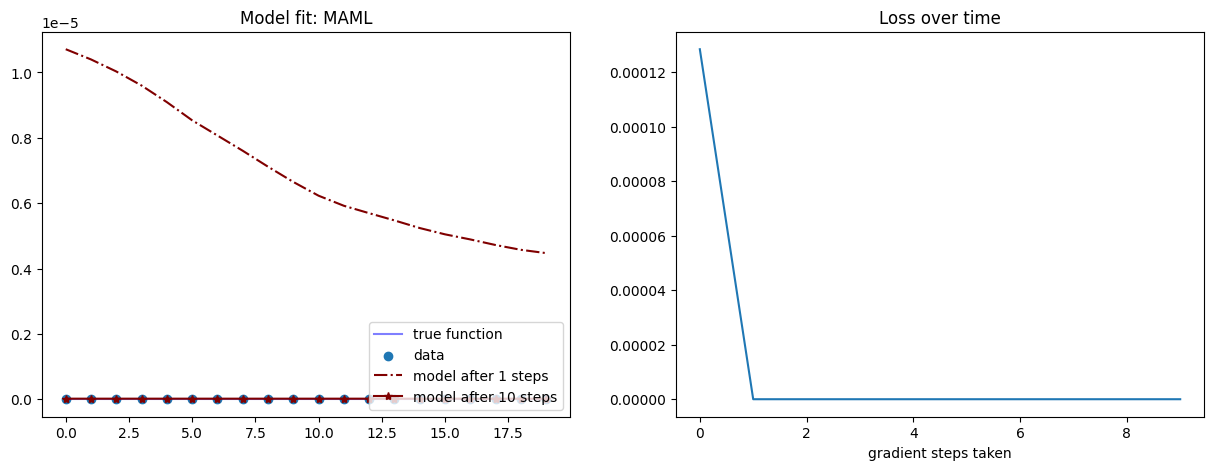

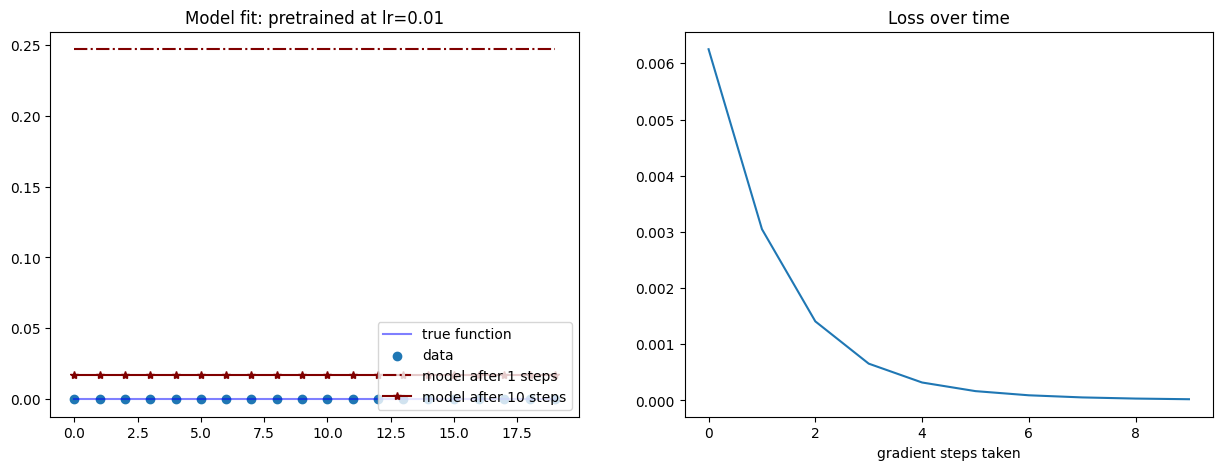

In [25]:
K = 20

X = pl[["Realized_Power"]].values
y = pl["Real_block"].values
seq, target = sample_data(X, y, SEQ_LEN, K)

plot_sampled_performance(maml.model, 'MAML', seq, target, K)
plot_sampled_performance(pretrained_model, 'pretrained at lr=0.01', seq, target, K)

C:\Users\DCLAB\AppData\Local\Temp\ipykernel_6664\3693235491.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs[step] = model(torch.tensor(X, dtype=torch.float)).cpu().detach().numpy()
C:\Users\DCLAB\AppData\Local\Temp\ipykernel_6664\3693235491.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial'] = initial_model(torch.tensor(X, dtype=torch.float)).cpu().detach().numpy()


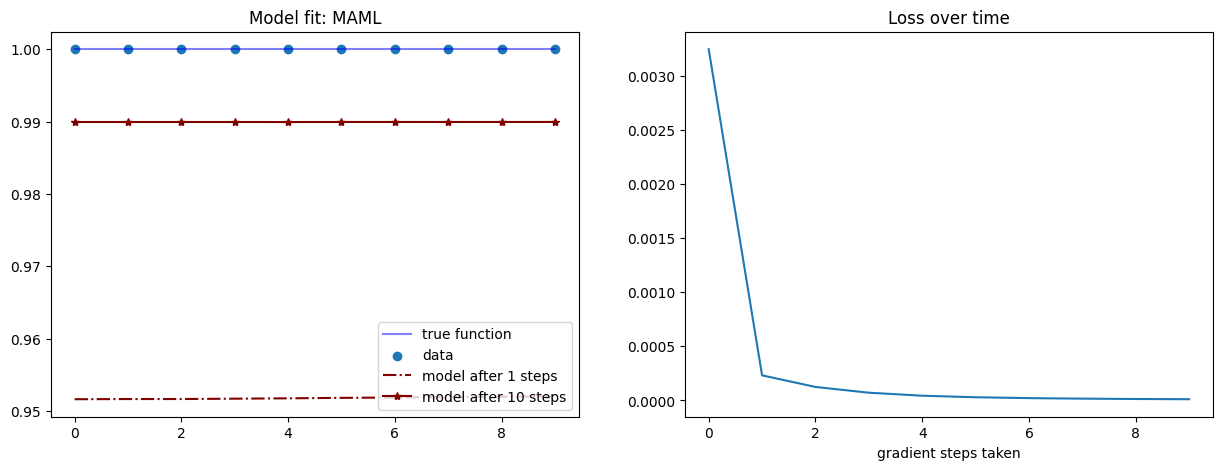

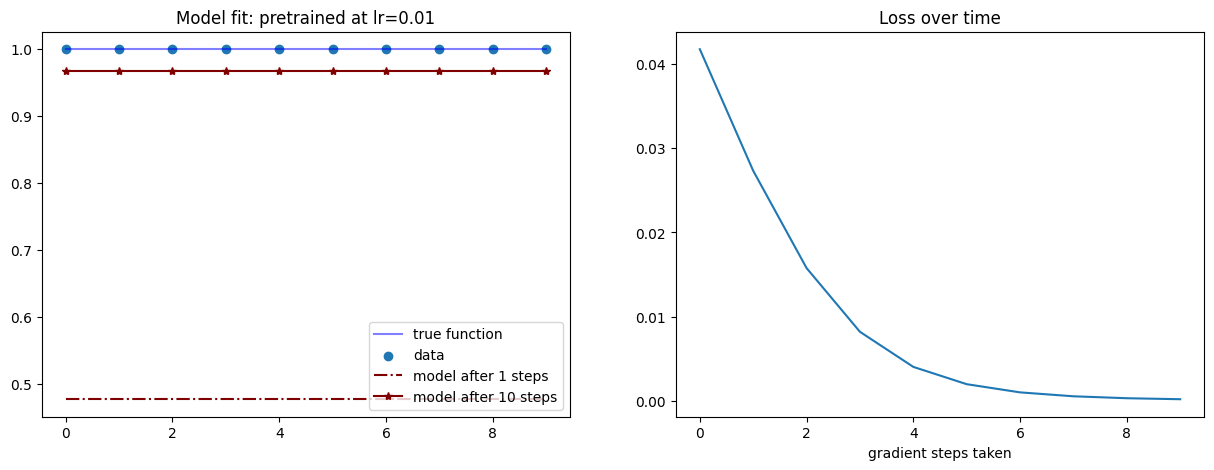

In [26]:
K = 10

X = pl[["Realized_Power"]].values
y = pl["Real_block"].values
seq, target = sample_data(X, y, SEQ_LEN, K)

plot_sampled_performance(maml.model, 'MAML', seq, target, K)
plot_sampled_performance(pretrained_model, 'pretrained at lr=0.01', seq, target, K)

C:\Users\DCLAB\AppData\Local\Temp\ipykernel_6664\3693235491.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs[step] = model(torch.tensor(X, dtype=torch.float)).cpu().detach().numpy()
C:\Users\DCLAB\AppData\Local\Temp\ipykernel_6664\3693235491.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs['initial'] = initial_model(torch.tensor(X, dtype=torch.float)).cpu().detach().numpy()


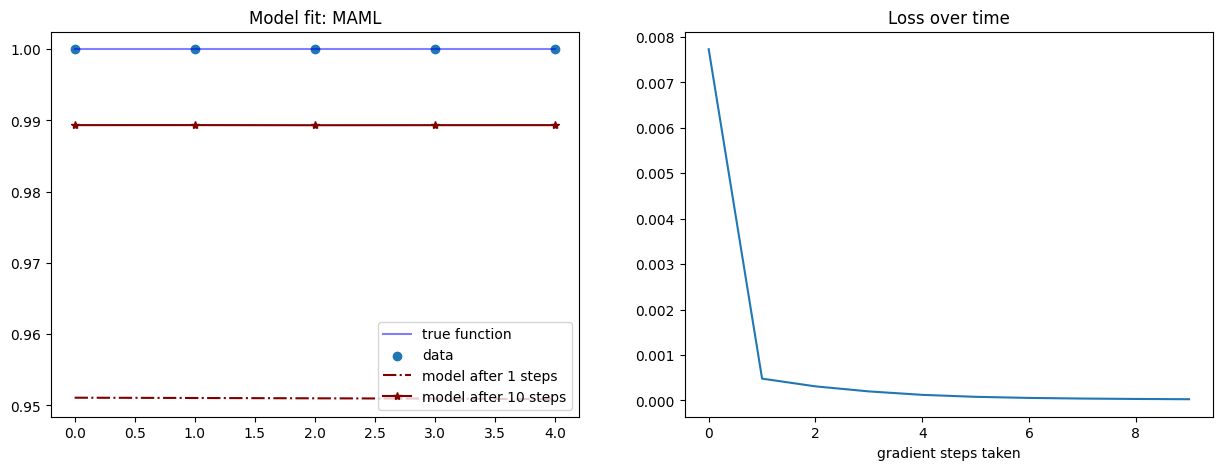

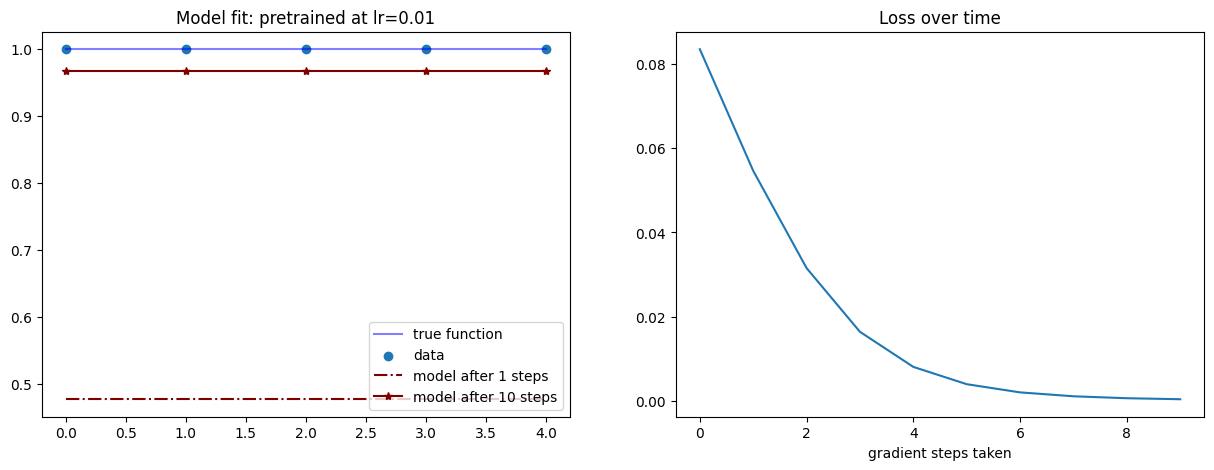

In [27]:
K = 5

X = pl[["Realized_Power"]].values
y = pl["Real_block"].values
seq, target = sample_data(X, y, SEQ_LEN, K)

plot_sampled_performance(maml.model, 'MAML', seq, target, K)
plot_sampled_performance(pretrained_model, 'pretrained at lr=0.01', seq, target, K)

# Result 2

In [28]:
X = pl[["Realized_Power"]].values
y = pl["Real_block"].values

In [29]:
train_loader, test_loader = train_test_seperate(X, y, SEQ_LEN, SPLIT, BATCH_SIZE)

# Meta Learning

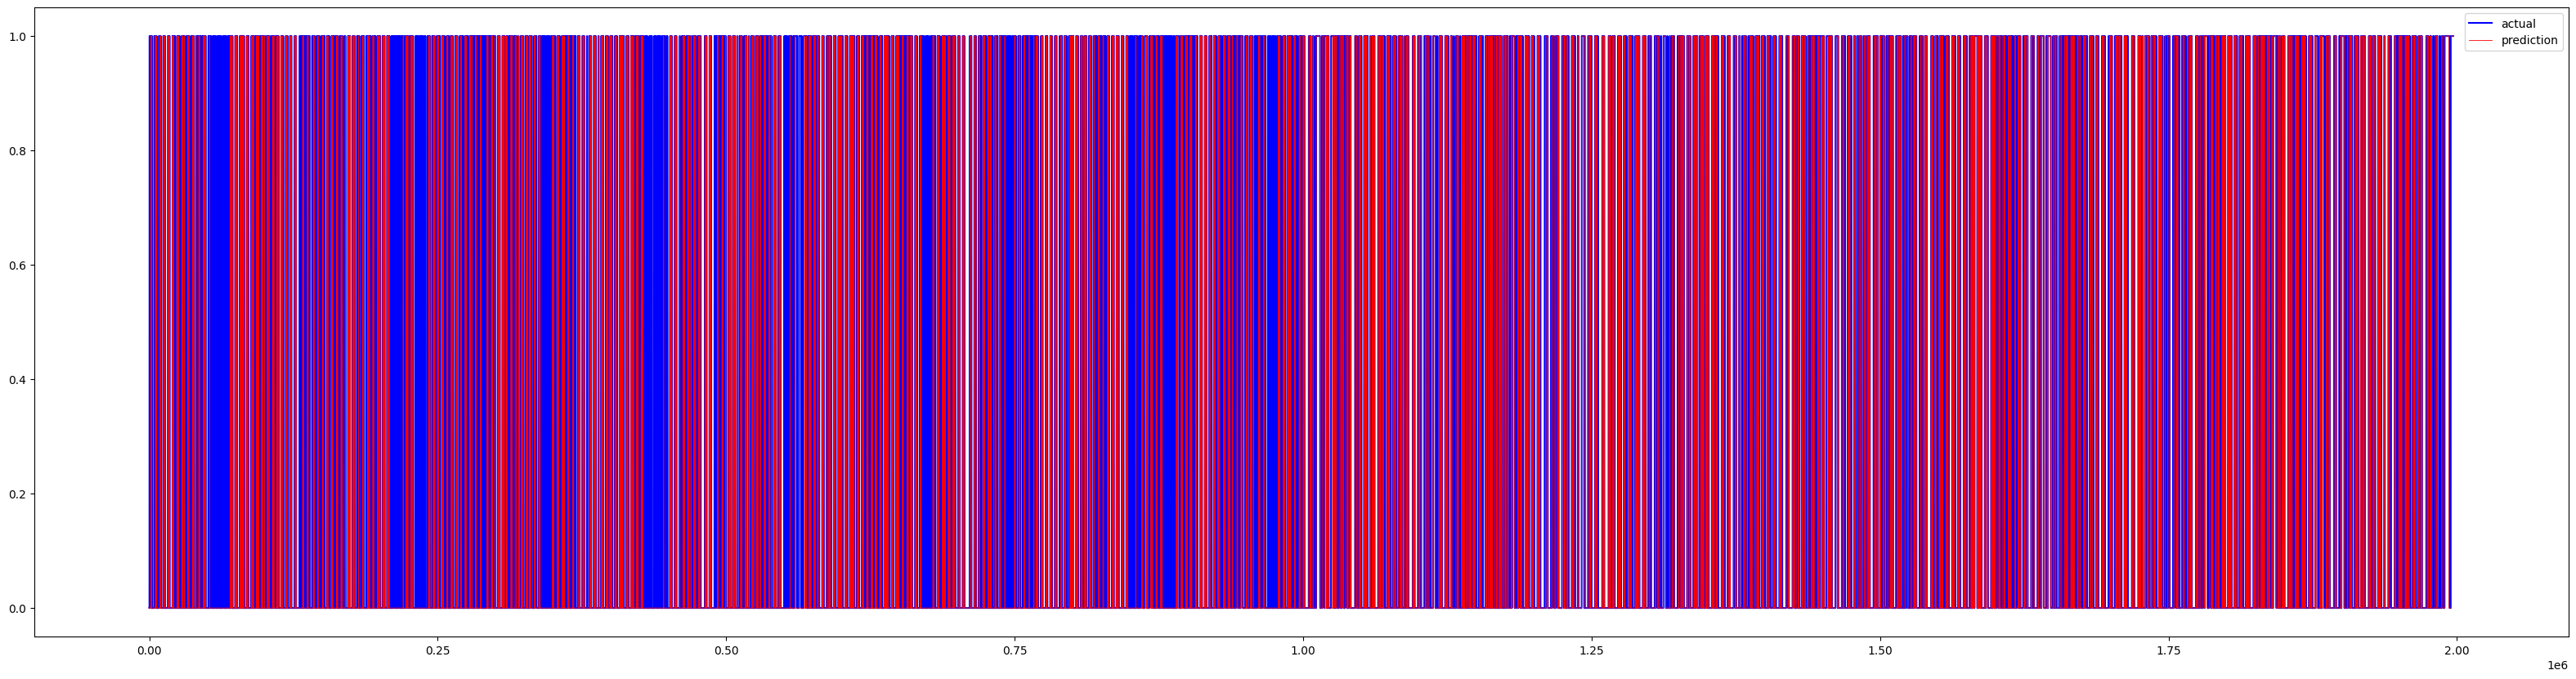


----------------------------------------------
the number of correct 1670042
the number of uncorrect 326737

confusion matrix
TP: 498021
TN: 1172021
FP: 18088
FN: 308649

accuracy: 0.8363679706166781


In [30]:
losses = []
n = len(test_loader)
with torch.no_grad():
    test_pred = []
    targetting = []
    for data in test_loader:
        seq, target = data 
        out = maml.model(seq)
        targetting += target.cpu().numpy().tolist()
        test_pred += out.cpu().numpy().round().tolist()
        
    actual = targetting
    total = test_pred       

    #plot
    plt.figure(figsize=(40,10))
    
    #signal
    plt.plot(actual[:],'b')
    plt.plot(total[:],'r', linewidth=0.6)
    plt.legend(['actual','prediction'])
    plt.show()

    t=np.array(actual[:])
    l=np.array(total[:])
    
    correct=0
    uncorrect=0
    FP=0;TP=0;FN=0;TN=0
    
    for i, j in zip(t, l):
        if(i-j==0):
            correct=correct+1
            if(j==1):TP=TP+1
            else:TN=TN+1
        else: 
            uncorrect=uncorrect+1
            if(j==1):FP=FP+1
            else:FN=FN+1
    
    all=correct+uncorrect
    acc=correct/all
    
    #accuracy (classification)
    print("\n----------------------------------------------")
    print('the number of correct', correct)
    print('the number of uncorrect', uncorrect)

    print("\n"+"confusion matrix")
    print("TP: "+str(TP))
    print("TN: "+str(TN))
    print("FP: "+str(FP)) 
    print("FN: "+str(FN))

    print('\n'+'accuracy:', acc)

# 일반모델 few-shot learning

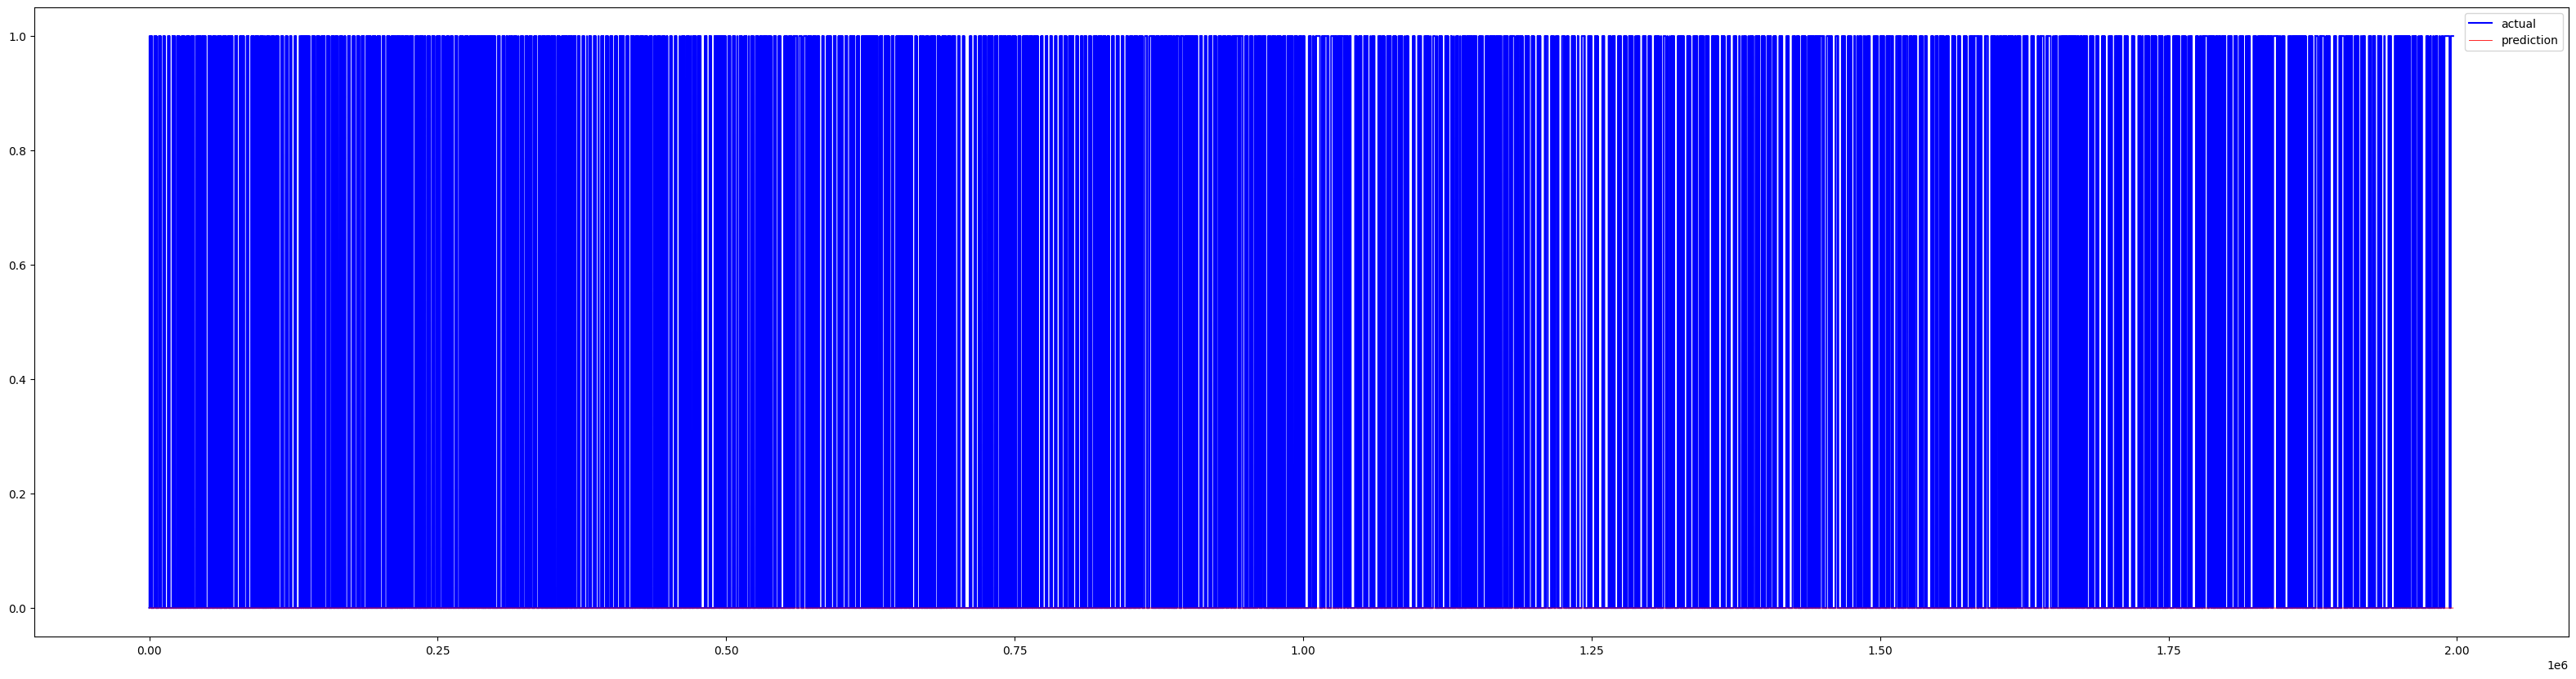


----------------------------------------------
the number of correct 1190109
the number of uncorrect 806670

confusion matrix
TP: 0
TN: 1190109
FP: 0
FN: 806670

accuracy: 0.5960143811608596


In [31]:
losses = []
n = len(test_loader)
with torch.no_grad():
    test_pred = []
    targetting = []
    for data in test_loader:
        seq, target = data 
        out = pretrained_model(seq)
        targetting += target.cpu().numpy().tolist()
        test_pred += out.cpu().numpy().round().tolist()
        
    actual = targetting
    total = test_pred       
    #plot
    plt.figure(figsize=(40,10))
    
    #signal
    plt.plot(actual[:],'b')
    plt.plot(total[:],'r', linewidth=0.6)
    plt.legend(['actual','prediction'])
    plt.show()

    t=np.array(actual[:])
    l=np.array(total[:])
    
    correct=0
    uncorrect=0
    FP=0;TP=0;FN=0;TN=0
    
    for i, j in zip(t, l):
        if(i-j==0):
            correct=correct+1
            if(j==1):TP=TP+1
            else:TN=TN+1
        else: 
            uncorrect=uncorrect+1
            if(j==1):FP=FP+1
            else:FN=FN+1
    
    all=correct+uncorrect
    acc=correct/all
    
    #accuracy (classification)
    print("\n----------------------------------------------")
    print('the number of correct', correct)
    print('the number of uncorrect', uncorrect)

    print("\n"+"confusion matrix")
    print("TP: "+str(TP))
    print("TN: "+str(TN))
    print("FP: "+str(FP)) 
    print("FN: "+str(FN))

    print('\n'+'accuracy:', acc)

---

# 한 개의 Task를 적용

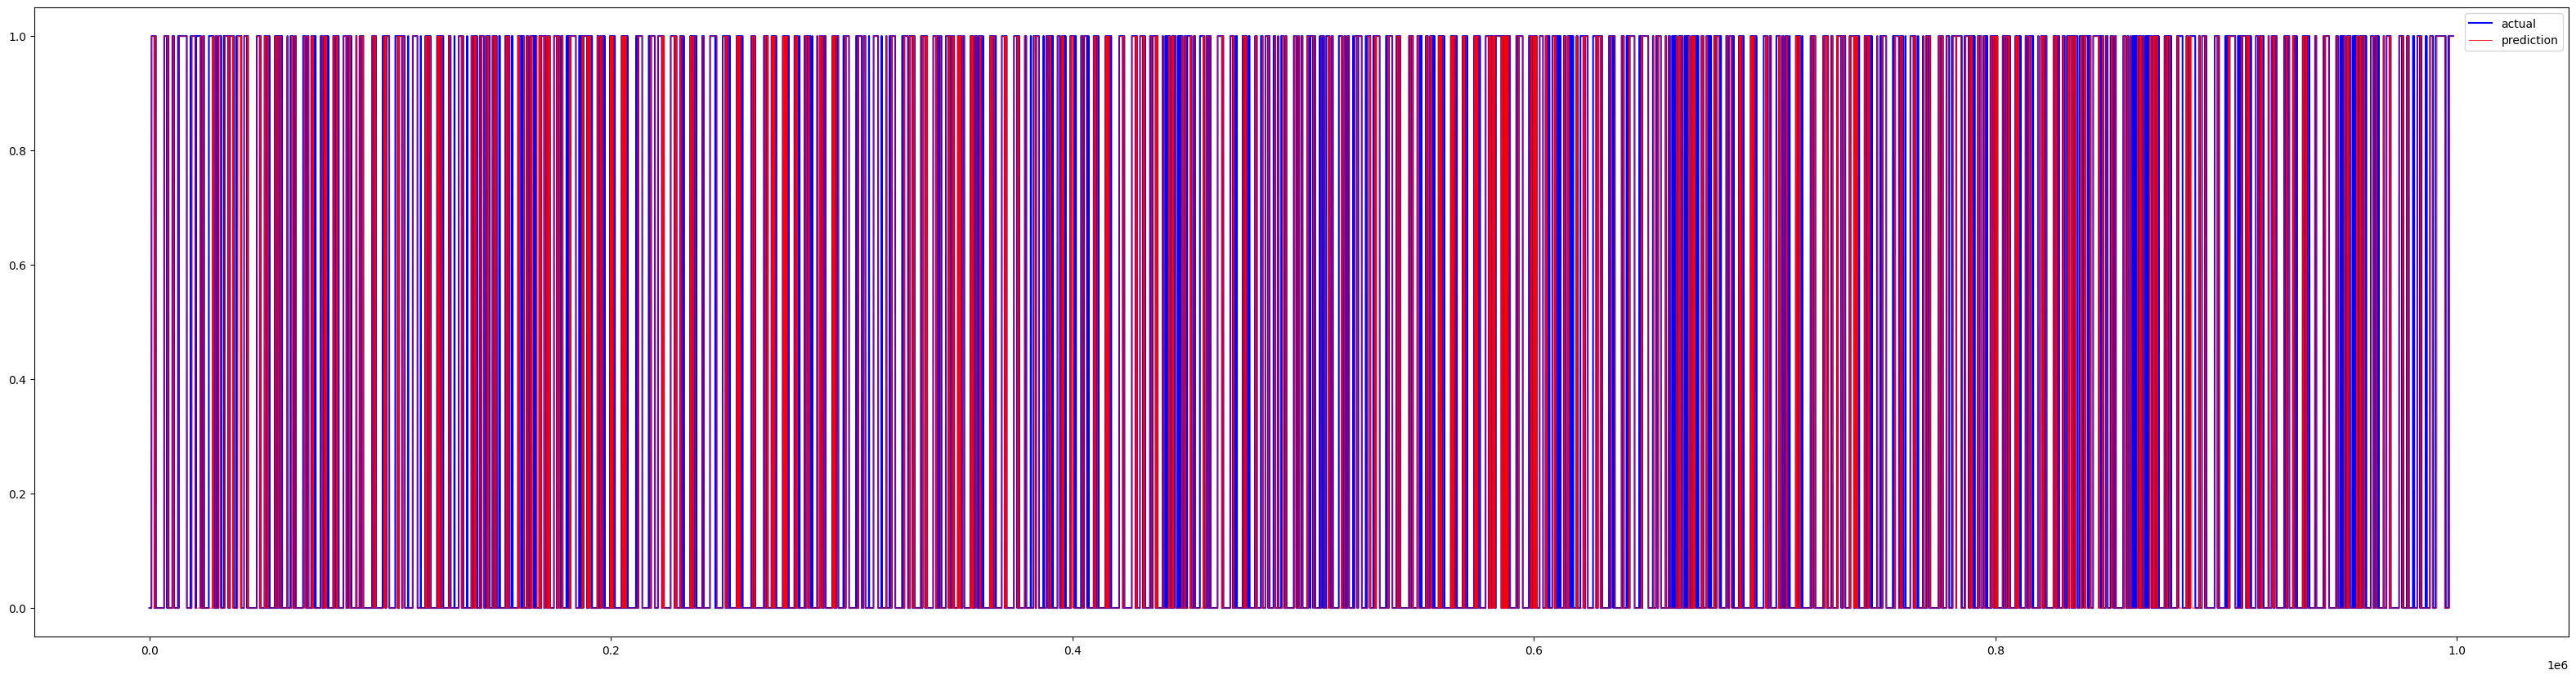


----------------------------------------------
the number of correct 892150
the number of uncorrect 106229

confusion matrix
TP: 329324
TN: 562826
FP: 11731
FN: 94498

accuracy: 0.8935985232061171


In [32]:
test_features, test_labels = Test_data(X, y, SEQ_LEN)
losses = []
n = len(test_loader)
with torch.no_grad():
    test_pred = []
    targetting = []

    seq = test_features
    target = test_labels
    out = maml.model(seq)
    targetting += target.cpu().numpy().tolist()
    test_pred += out.cpu().numpy().round().tolist()
    
    actual = targetting
    total = test_pred       

    #plot
    plt.figure(figsize=(40,10))
    
    #signal
    plt.plot(actual[:],'b')
    plt.plot(total[:],'r', linewidth=0.6)
    plt.legend(['actual','prediction'])
    plt.show()

    t=np.array(actual[:])
    l=np.array(total[:])
    
    correct=0
    uncorrect=0
    FP=0;TP=0;FN=0;TN=0
    
    for i, j in zip(t, l):
        if(i-j==0):
            correct=correct+1
            if(j==1):TP=TP+1
            else:TN=TN+1
        else: 
            uncorrect=uncorrect+1
            if(j==1):FP=FP+1
            else:FN=FN+1
    
    all=correct+uncorrect
    acc=correct/all
    
    #accuracy (classification)
    print("\n----------------------------------------------")
    print('the number of correct', correct)
    print('the number of uncorrect', uncorrect)

    print("\n"+"confusion matrix")
    print("TP: "+str(TP))
    print("TN: "+str(TN))
    print("FP: "+str(FP)) 
    print("FN: "+str(FN))

    print('\n'+'accuracy:', acc)

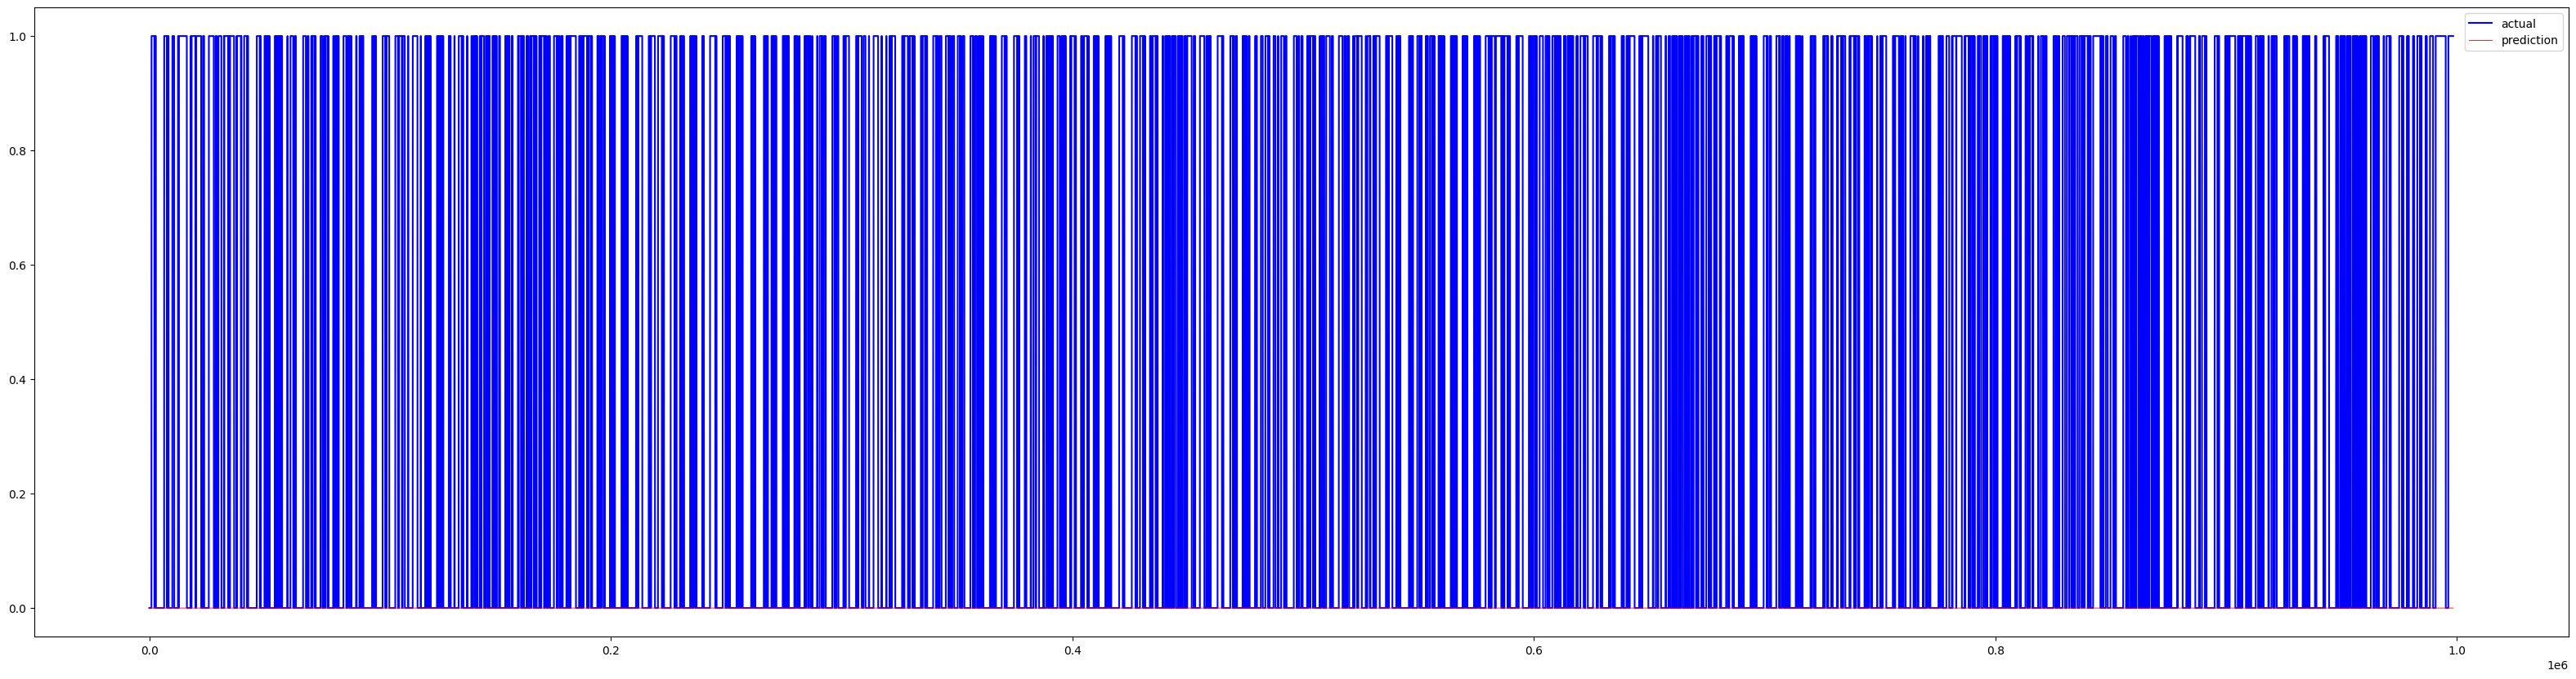


----------------------------------------------
the number of correct 574557
the number of uncorrect 423822

confusion matrix
TP: 0
TN: 574557
FP: 0
FN: 423822

accuracy: 0.5754898690777751


In [33]:
losses = []
n = len(test_loader)
with torch.no_grad():
    test_pred = []
    targetting = []

    seq = test_features
    target = test_labels
    out = pretrained_model(seq)
    targetting += target.cpu().numpy().tolist()
    test_pred += out.cpu().numpy().round().tolist()
    
    actual = targetting
    total = test_pred       

    #plot
    plt.figure(figsize=(40,10))
    
    #signal
    plt.plot(actual[:],'b')
    plt.plot(total[:],'r', linewidth=0.6)
    plt.legend(['actual','prediction'])
    plt.show()

    t=np.array(actual[:])
    l=np.array(total[:])
    
    correct=0
    uncorrect=0
    FP=0;TP=0;FN=0;TN=0
    
    for i, j in zip(t, l):
        if(i-j==0):
            correct=correct+1
            if(j==1):TP=TP+1
            else:TN=TN+1
        else: 
            uncorrect=uncorrect+1
            if(j==1):FP=FP+1
            else:FN=FN+1
    
    all=correct+uncorrect
    acc=correct/all
    
    #accuracy (classification)
    print("\n----------------------------------------------")
    print('the number of correct', correct)
    print('the number of uncorrect', uncorrect)

    print("\n"+"confusion matrix")
    print("TP: "+str(TP))
    print("TN: "+str(TN))
    print("FP: "+str(FP)) 
    print("FN: "+str(FN))

    print('\n'+'accuracy:', acc)

---

# result 1개

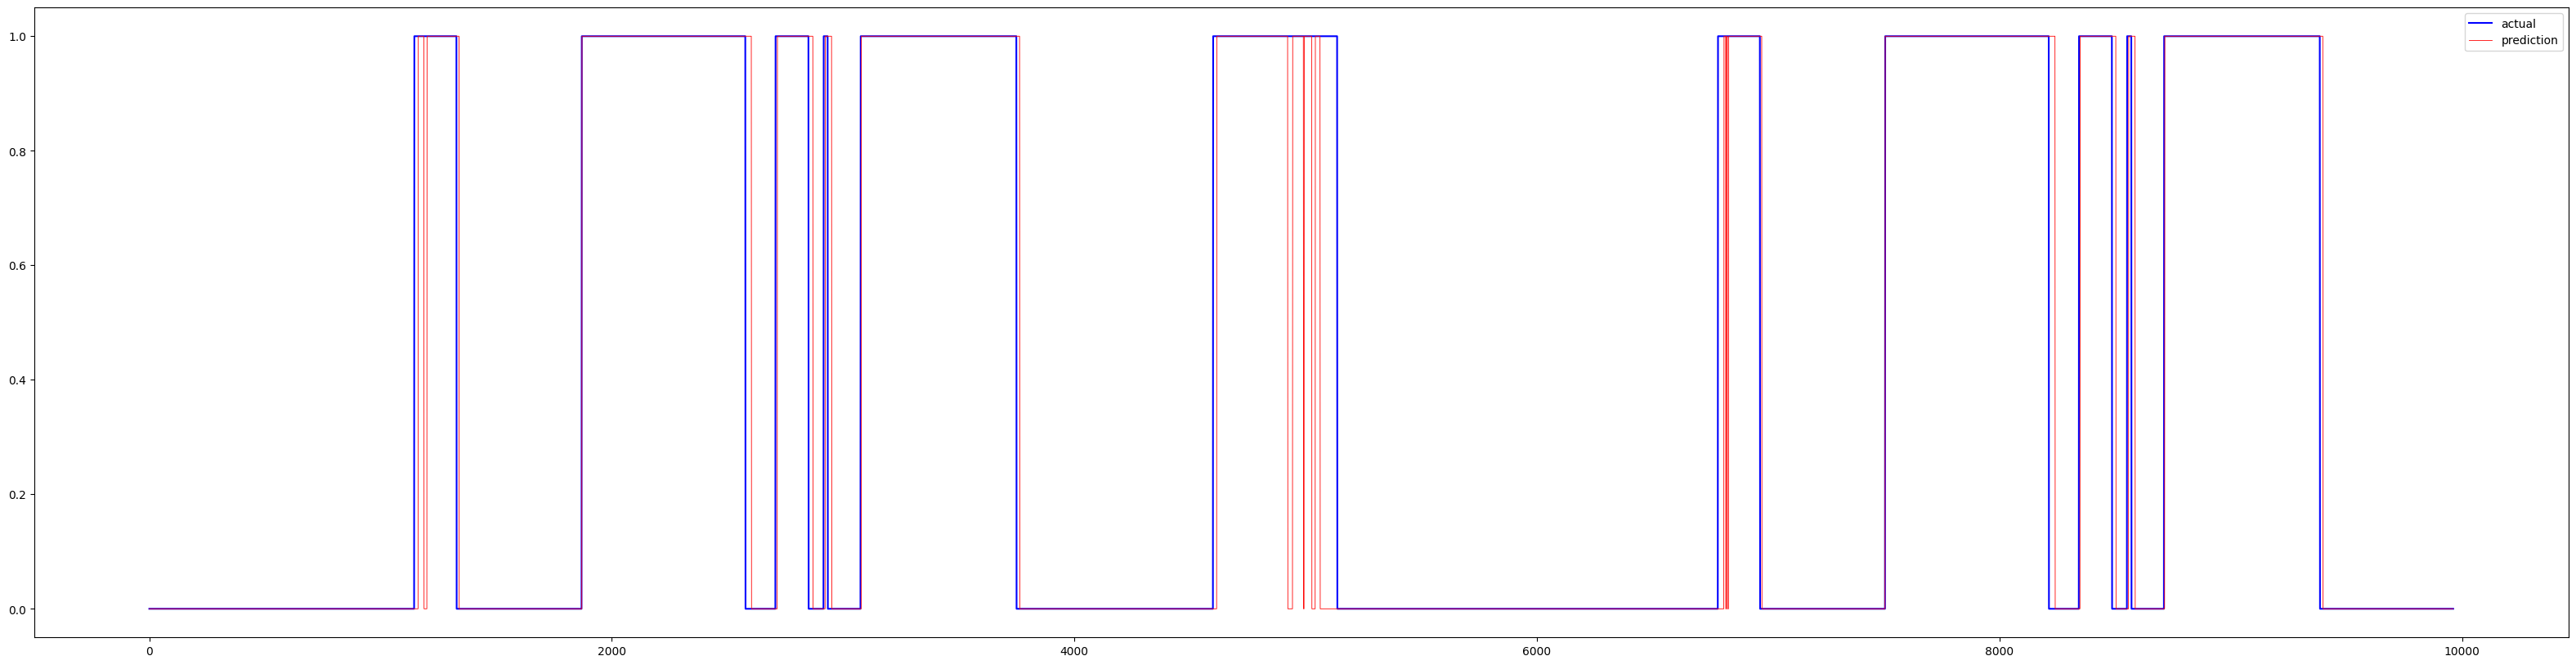


----------------------------------------------
the number of correct 9568
the number of uncorrect 395

confusion matrix
TP: 3762
TN: 5806
FP: 168
FN: 227

accuracy: 0.960353307236776


In [34]:
One_test_features, One_test_labels = One_Test_data(X, y, SEQ_LEN)

losses = []
n = len(test_loader)
with torch.no_grad():
    test_pred = []
    targetting = []

    seq = One_test_features
    target = One_test_labels
    out = maml.model(seq)
    targetting += target.cpu().numpy().tolist()
    test_pred += out.cpu().numpy().round().tolist()
    
    actual = targetting
    total = test_pred       

    #plot
    plt.figure(figsize=(40,10))
    
    #signal
    plt.plot(actual[:],'b')
    plt.plot(total[:],'r', linewidth=0.6)
    plt.legend(['actual','prediction'])
    plt.show()

    t=np.array(actual[:])
    l=np.array(total[:])
    
    correct=0
    uncorrect=0
    FP=0;TP=0;FN=0;TN=0
    
    for i, j in zip(t, l):
        if(i-j==0):
            correct=correct+1
            if(j==1):TP=TP+1
            else:TN=TN+1
        else: 
            uncorrect=uncorrect+1
            if(j==1):FP=FP+1
            else:FN=FN+1
    
    all=correct+uncorrect
    acc=correct/all
    
    #accuracy (classification)
    print("\n----------------------------------------------")
    print('the number of correct', correct)
    print('the number of uncorrect', uncorrect)

    print("\n"+"confusion matrix")
    print("TP: "+str(TP))
    print("TN: "+str(TN))
    print("FP: "+str(FP)) 
    print("FN: "+str(FN))

    print('\n'+'accuracy:', acc)

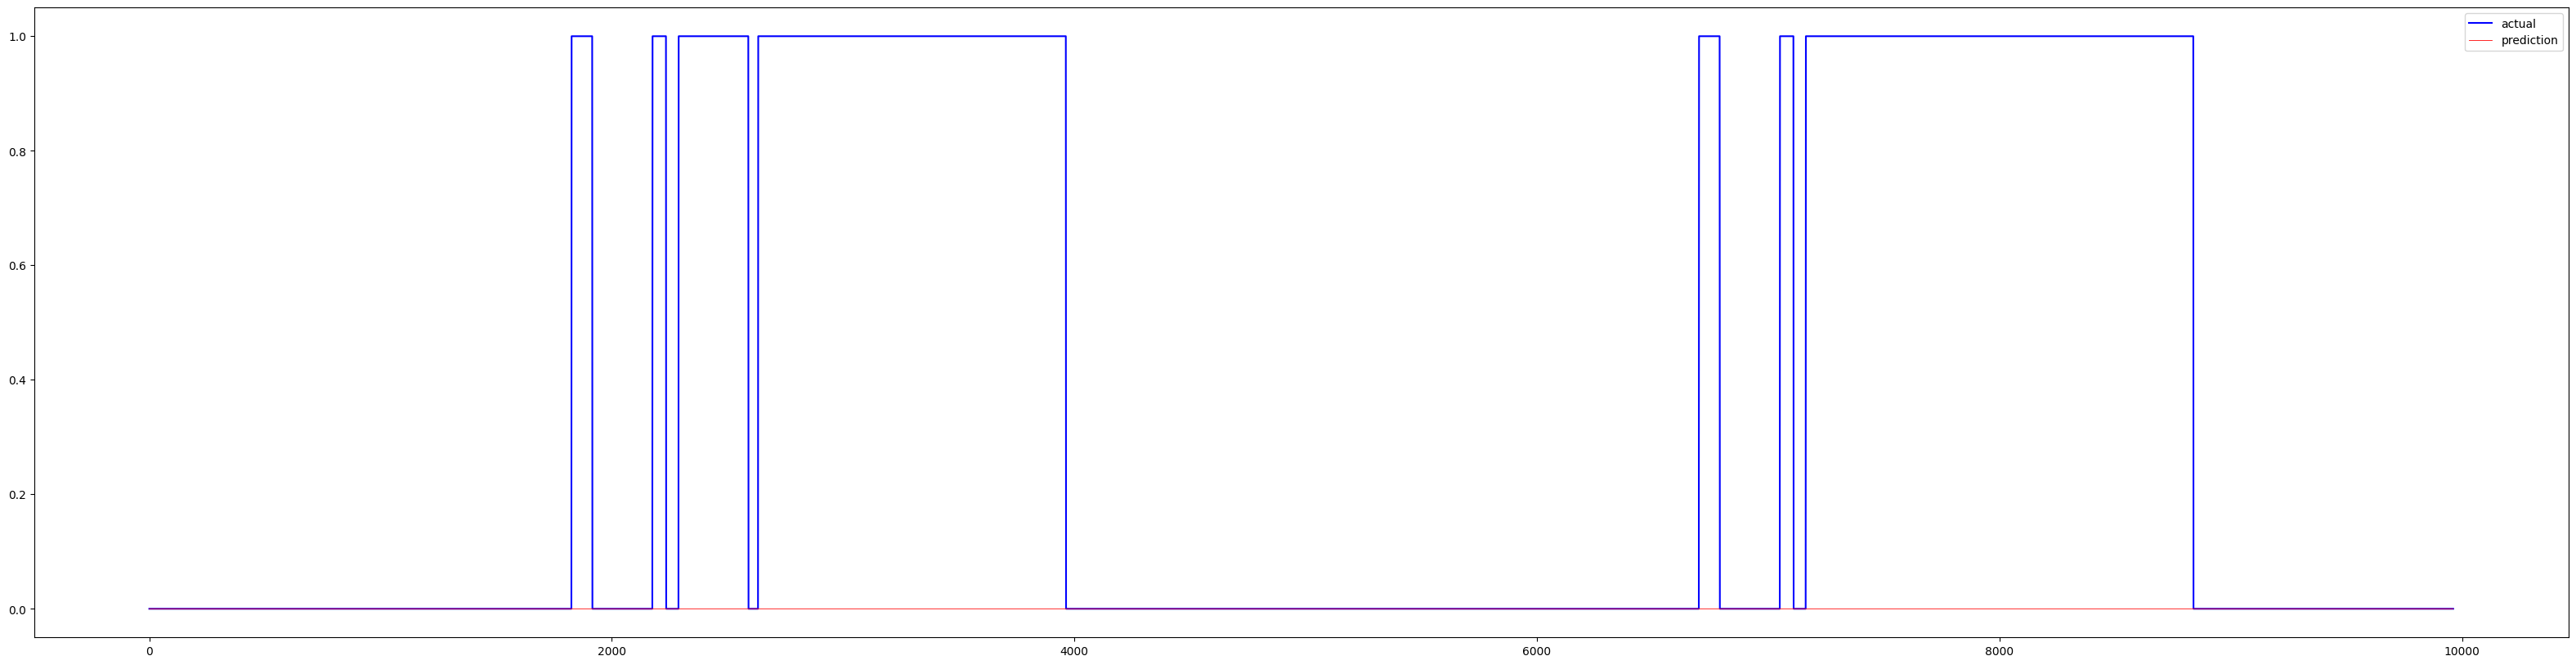


----------------------------------------------
the number of correct 6356
the number of uncorrect 3607

confusion matrix
TP: 0
TN: 6356
FP: 0
FN: 3607

accuracy: 0.6379604536786109


In [35]:
One_test_features, One_test_labels = One_Test_data(X, y, SEQ_LEN)
losses = []
n = len(test_loader)
with torch.no_grad():
    test_pred = []
    targetting = []

    seq = One_test_features
    target = One_test_labels
    out = pretrained_model(seq)
    targetting += target.cpu().numpy().tolist()
    test_pred += out.cpu().numpy().round().tolist()
    
    actual = targetting
    total = test_pred       

    #plot
    plt.figure(figsize=(40,10))
    
    #signal
    plt.plot(actual[:],'b')
    plt.plot(total[:],'r', linewidth=0.6)
    plt.legend(['actual','prediction'])
    plt.show()

    t=np.array(actual[:])
    l=np.array(total[:])
    
    correct=0
    uncorrect=0
    FP=0;TP=0;FN=0;TN=0
    
    for i, j in zip(t, l):
        if(i-j==0):
            correct=correct+1
            if(j==1):TP=TP+1
            else:TN=TN+1
        else: 
            uncorrect=uncorrect+1
            if(j==1):FP=FP+1
            else:FN=FN+1
    
    all=correct+uncorrect
    acc=correct/all
    
    #accuracy (classification)
    print("\n----------------------------------------------")
    print('the number of correct', correct)
    print('the number of uncorrect', uncorrect)

    print("\n"+"confusion matrix")
    print("TP: "+str(TP))
    print("TN: "+str(TN))
    print("FP: "+str(FP)) 
    print("FN: "+str(FN))

    print('\n'+'accuracy:', acc)